<a href="https://colab.research.google.com/github/Anldrnz/DeepOnet/blob/main/DeepOnet_Integral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
from sklearn import gaussian_process as gp
from scipy import interpolate
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import os
import time
import matplotlib.pyplot as plt

## ODE Data

In [25]:
from functools import wraps

def map_elementwise(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        container, idx = None, None
        for arg in args:
            if type(arg) in (list, tuple, dict):
                container, idx = type(arg), arg.keys() if type(arg) == dict else len(arg)
                break
        if container is None:
            for value in kwargs.values():
                if type(value) in (list, tuple, dict):
                    container, idx = type(value), value.keys() if type(value) == dict else len(value)
                    break
        if container is None:
            return func(*args, **kwargs)
        elif container in (list, tuple):
            get = lambda element, i: element[i] if type(element) is container else element
            return container(wrapper(*[get(arg, i) for arg in args], 
                                     **{key:get(value, i) for key, value in kwargs.items()}) 
                             for i in range(idx))
        elif container is dict:
            get = lambda element, key: element[key] if type(element) is dict else element
            return {key:wrapper(*[get(arg, key) for arg in args], 
                                **{key_:get(value_, key) for key_, value_ in kwargs.items()}) 
                    for key in idx}
    return wrapper

class Data:
    '''Standard data format. 
    '''
    def __init__(self, X_train=None, y_train=None, X_test=None, y_test=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.__device = None
        self.__dtype = None
    
    def get_batch(self, batch_size):
        @map_elementwise
        def batch_mask(X, num):
            return np.random.choice(X.size(0), num, replace=False)
        @map_elementwise
        def batch(X, mask):
            return X[mask]
        mask = batch_mask(self.y_train, batch_size)
        return batch(self.X_train, mask), batch(self.y_train, mask)
    
    @property
    def device(self):
        return self.__device
    
    @property
    def dtype(self):
        return self.__dtype
    
    @device.setter    
    def device(self, d):
        if d == 'cpu':
            self.__to_cpu()
            self.__device = torch.device('cpu')
        elif d == 'gpu':
            self.__to_gpu()
            self.__device = torch.device('cuda')
        else:
            raise ValueError
    
    @dtype.setter     
    def dtype(self, d):
        if d == 'float':
            self.__to_float()
            self.__dtype = torch.float32
        elif d == 'double':
            self.__to_double()
            self.__dtype = torch.float64
        else:
            raise ValueError
    
    @property
    def dim(self):
        if isinstance(self.X_train, np.ndarray):
            return self.X_train.shape[-1]
        elif isinstance(self.X_train, torch.Tensor):
            return self.X_train.size(-1)
    
    @property
    def K(self):
        if isinstance(self.y_train, np.ndarray):
            return self.y_train.shape[-1]
        elif isinstance(self.y_train, torch.Tensor):
            return self.y_train.size(-1)
    
    @property
    def X_train_np(self):
        return Data.to_np(self.X_train)
    
    @property
    def y_train_np(self):
        return Data.to_np(self.y_train)
    
    @property
    def X_test_np(self):
        return Data.to_np(self.X_test)
    
    @property
    def y_test_np(self):
        return Data.to_np(self.y_test)
    
    @staticmethod
    @map_elementwise
    def to_np(d):
        if isinstance(d, np.ndarray) or d is None:
            return d
        elif isinstance(d, torch.Tensor):
            return d.cpu().detach().numpy()
        else:
            raise ValueError
    
    def __to_cpu(self):
        @map_elementwise
        def trans(d):
            if isinstance(d, np.ndarray):
                return torch.DoubleTensor(d)
            elif isinstance(d, torch.Tensor):
                return d.cpu()
        for d in ['X_train', 'y_train', 'X_test', 'y_test']:
            setattr(self, d, trans(getattr(self, d)))
    
    def __to_gpu(self):
        @map_elementwise
        def trans(d):
            if isinstance(d, np.ndarray):
                return torch.cuda.DoubleTensor(d)
            elif isinstance(d, torch.Tensor):
                return d.cuda()
        for d in ['X_train', 'y_train', 'X_test', 'y_test']:
            setattr(self, d, trans(getattr(self, d)))
    
    def __to_float(self):
        if self.device is None: 
            raise RuntimeError('device is not set')
        @map_elementwise
        def trans(d):
            if isinstance(d, torch.Tensor):
                return d.float()
        for d in ['X_train', 'y_train', 'X_test', 'y_test']:
            setattr(self, d, trans(getattr(self, d)))
    
    def __to_double(self):
        if self.device is None: 
            raise RuntimeError('device is not set')
        @map_elementwise
        def trans(d):
            if isinstance(d, torch.Tensor):
                return d.double()
        for d in ['X_train', 'y_train', 'X_test', 'y_test']:
            setattr(self, d, trans(getattr(self, d)))

In [26]:
class AntideData(Data):
    '''Data for learning the antiderivative operator.
    '''
    def __init__(self, s0, sensors, p, length_scale, train_num, test_num):
        super(AntideData, self).__init__()
        self.s0 = s0
        self.sensors = sensors
        self.p = p
        self.length_scale = length_scale
        self.train_num = train_num
        self.test_num = test_num
        self.__init_data()
        
    def __init_data(self):
        features = 2000
        train = self.__gaussian_process(self.train_num, features)
        test = self.__gaussian_process(self.test_num, features)
        self.X_train, self.y_train = self.__generate(train)
        self.X_test, self.y_test = self.__generate(test)
        
    def __generate(self, gps):
        def generate(gp):
            u = interpolate.interp1d(np.linspace(0, 1, num=gp.shape[-1]), gp, kind='cubic', copy=False, assume_sorted=True)
            x = np.sort(np.random.rand(self.p))
            y = solve_ivp(lambda t, y: u(t), [0, 1], self.s0, 'RK45', x).y[0]
            u_sensors = u(np.linspace(0, 1, num=self.sensors))
            return np.hstack([np.tile(u_sensors, (self.p, 1)), x[:, None], y[:, None]])
        res = np.vstack(list(map(generate, gps)))
        return (res[..., :-2], res[..., -2:-1]), res[..., -1:]
    
    def __gaussian_process(self, num, features):
        x = np.linspace(0, 1, num=features)[:, None]
        A = gp.kernels.RBF(length_scale=self.length_scale)(x)
        L = np.linalg.cholesky(A + 1e-13 * np.eye(features))
        return (L @ np.random.randn(features, num)).transpose()

## Trials for functions

In [ ]:
import matplotlib.pyplot as plt

def my_gaussian_process(num, features, T, scale):
        x = np.linspace(0, T, num=features)[:, None]
        K = gp.kernels.RBF(length_scale=scale)(x)
        L = np.linalg.cholesky(K + 1e-13 * np.eye(features))
        return (L @ np.random.randn(features, num)).transpose()

def my_line_func(num, features, T):
        x = np.linspace(0, T, num=features)[:, None]
        
        return (L @ np.random.randn(features, num)).transpose()

def my_sense(gps, T, sensor_in):
        x = np.linspace(0, T, num=gps.shape[1])
        res = map(lambda y: interpolate.interp1d(x, y, kind='cubic', copy=False, assume_sorted=True
            )(np.linspace(0, T, num=sensor_in)), gps)
        result = list(res)
        return np.vstack(result)

def g(y, u, t):
        return u

def my_solve(gps, T, sensor_out, s0):
        x = np.linspace(0, T, num=gps.shape[1])
        interval = np.linspace(0, T, num=sensor_out) if sensor_out > 1 else [T]
        def solve(y):
            u = interpolate.interp1d(x, y, kind='cubic', copy=False, assume_sorted=True)
            return solve_ivp(lambda t, y: g(y, u(t), t), [0, T], s0, 'RK45', interval, max_step=0.05).y[0]
        res = map(solve, gps)
        result = list(res)
        return np.vstack(result)

In [ ]:
T = 1
features = 1000 * T
train_num = 1000
length_scale = 0.2
s0 = [0]
sensor_in = 100
sensor_out = 100

train = my_gaussian_process(train_num, features, T, length_scale)
#train = np.random.rand()*np.ones((1000, 1000))
train_X = my_sense(train, T, sensor_in)
train_Y = my_solve(train, T, sensor_out, s0)

In [ ]:
#print(train_X)
print(len(train_Y), len(train_Y[0]))

1000 100


In [ ]:
# plot gaussian process raw training data
plt.figure(figsize=(20, 8))
for i in range(int(len(train)*0.001)):
  plt.plot(train[i])

In [ ]:
# plot X training data
plt.clf()
plt.figure(figsize=(20, 8))
for i in range(int(len(train_X)*0.001)):
  plt.plot(train_X[i])

# __sense function crops the data tenfold, length drops from 1000 to 100 without changing the behaviour of data.

In [ ]:
# plot Y training data
plt.clf()
plt.figure(figsize=(20, 8))
for i in range(int(len(train_Y)*0.001)):
  plt.plot(train_Y[i])

# __solve function finds the operator result as numeric solution. (solve_ivp result)

## Modules for Learning

In [30]:
class Module(torch.nn.Module):
    '''Standard module format.
    '''
    def __init__(self):
        super(Module, self).__init__()
        self.activation = None
        self.initializer = None
        
        self.__device = None
        self.__dtype = None
        
    @property
    def device(self):
        return self.__device
        
    @property
    def dtype(self):
        return self.__dtype

    @device.setter
    def device(self, d):
        if d == 'cpu':
            self.cpu()
            for module in self.modules():
                if isinstance(module, Module):
                    module.__device = torch.device('cpu')
        elif d == 'gpu':
            self.cuda()
            for module in self.modules():
                if isinstance(module, Module):
                    module.__device = torch.device('cuda')
        else:
            raise ValueError
    
    @dtype.setter
    def dtype(self, d):
        if d == 'float':
            self.to(torch.float32)
            for module in self.modules():
                if isinstance(module, Module):
                    module.__dtype = torch.float32
        elif d == 'double':
            self.to(torch.float64)
            for module in self.modules():
                if isinstance(module, Module):
                    module.__dtype = torch.float64
        else:
            raise ValueError

    @property
    def act(self):
        if callable(self.activation):
            return self.activation
        elif self.activation == 'sigmoid':
            return torch.sigmoid
        elif self.activation == 'relu':
            return torch.relu
        elif self.activation == 'tanh':
            return torch.tanh
        elif self.activation == 'elu':
            return torch.elu
        else:
            raise NotImplementedError

    @property
    def weight_init_(self):
        if callable(self.initializer):
            return self.initializer
        elif self.initializer == 'He normal':
            return torch.nn.init.kaiming_normal_
        elif self.initializer == 'He uniform':
            return torch.nn.init.kaiming_uniform_
        elif self.initializer == 'Glorot normal':
            return torch.nn.init.xavier_normal_
        elif self.initializer == 'Glorot uniform':
            return torch.nn.init.xavier_uniform_
        elif self.initializer == 'orthogonal':
            return torch.nn.init.orthogonal_
        elif self.initializer == 'default':
            if self.activation == 'relu':
                return torch.nn.init.kaiming_normal_
            elif self.activation == 'tanh':
                return torch.nn.init.orthogonal_
            else:
                return lambda x: None
        else:
            raise NotImplementedError
            
    @map_elementwise
    def _to_tensor(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=self.dtype, device=self.device)
        return x
            
class Map(Module):
    '''Structure-oriented neural network used as a general map based on designing architecture.
    '''
    def __init__(self):
        super(Map, self).__init__()
    
    def predict(self, x, returnnp=False):
        x = self._to_tensor(x)
        return self(x).cpu().detach().numpy() if returnnp else self(x)

In [31]:
class FNN(Map):
    '''Fully-connected neural network.
    Note that
    len(size) >= 2,
    [..., N1, -N2, ...] denotes a linear layer from dim N1 to N2 without bias,
    [..., N, 0] denotes an identity map (as output linear layer).
    '''
    def __init__(self, size, activation='relu', initializer='default'):
        super(FNN, self).__init__()
        self.size = size
        self.activation = activation
        self.initializer = initializer
        
        self.ms = self.__init_modules()
        self.__initialize()
        
    def forward(self, x):
        for i in range(1, len(self.size) - 1):
            x = self.act(self.ms['LinM{}'.format(i)](x))
        return self.ms['LinM{}'.format(len(self.size) - 1)](x) if self.size[-1] != 0 else x
    
    def __init_modules(self):
        modules = nn.ModuleDict()
        for i in range(1, len(self.size)):
            if self.size[i] != 0:
                bias = True if self.size[i] > 0 else False
                modules['LinM{}'.format(i)] = nn.Linear(abs(self.size[i - 1]), abs(self.size[i]), bias)
        return modules
    
    def __initialize(self):
        for i in range(1, len(self.size)):
            if self.size[i] != 0: 
                self.weight_init_(self.ms['LinM{}'.format(i)].weight)
                if self.size[i] > 0:
                    nn.init.constant_(self.ms['LinM{}'.format(i)].bias, 0)

In [32]:
class DeepONet(Map):
    '''Deep operator network.
    Input: ([batch size, branch_dim], [batch size, trunk_dim])
    Output: [batch size, 1]
    '''
    def __init__(self, branch_size, trunk_size, activation='relu', initializer='Glorot normal'):
        super(DeepONet, self).__init__()
        self.branch_size = branch_size
        self.trunk_size = trunk_size
        self.activation = activation
        self.initializer = initializer
        
        self.ms = self.__init_modules()
        self.ps = self.__init_params()
        
    def forward(self, x):
        x_branch, x_trunk = self.ms['Branch'](x[0]), self.ms['Trunk'](x[1])
        return torch.sum(x_branch * x_trunk, dim=-1, keepdim=True) + self.ps['bias']
        
    def __init_modules(self):
        modules = nn.ModuleDict()
        modules['Branch'] = FNN(self.branch_size, self.activation, self.initializer)
        modules['Trunk'] = FNN(self.trunk_size, self.activation, self.initializer)
        return modules
            
    def __init_params(self):
        params = nn.ParameterDict()
        params['bias'] = nn.Parameter(torch.zeros([1]))
        return params

## Run the model

In [42]:
class Brain:
    '''Runner based on torch.
    '''
    @classmethod
    def Init(cls, data, net, criterion, optimizer, lr, iterations, batch_size=None, 
             print_every=1000, save=False, callback=None, dtype='float', device='cpu'):
        cls.brain = cls(data, net, criterion, optimizer, lr, iterations, batch_size, 
                         print_every, save, callback, dtype, device)
        
    @classmethod
    def Run(cls):
        cls.brain.run()
        
    @classmethod
    def Restore(cls):
        cls.brain.restore()
        
    @classmethod
    def Output(cls, data=True, best_model=True, loss_history=True, info=None, path=None, **kwargs):
        cls.output(data, best_model, loss_history, info, path, **kwargs)

    def __init__(self, data, net, criterion, optimizer, lr, iterations, batch_size, 
                 print_every, save, callback, dtype, device):
        self.data = data
        self.net = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr = lr
        self.iterations = iterations
        self.batch_size = batch_size
        self.print_every = print_every
        self.save = save
        self.callback = callback
        self.dtype = dtype
        self.device = device
        
        self.loss_history = None
        self.encounter_nan = False
        self.best_model = None
        
        self.__optimizer = None
        self.__criterion = None
    
    def run(self):
        self.__init_brain()
        print('Training...', flush=True)
        loss_history = []
        for i in range(self.iterations + 1):
            if self.batch_size is not None:
                X_train, y_train = self.data.get_batch(self.batch_size)
                loss = self.__criterion(self.net(X_train), y_train)
            else:
                loss = self.__criterion(self.net(self.data.X_train), self.data.y_train)
            if i % self.print_every == 0 or i == self.iterations:
                loss_test = self.__criterion(self.net(self.data.X_test), self.data.y_test)
                loss_history.append([i, loss.item(), loss_test.item()])
                print('{:<9}Train loss: {:<25}Test loss: {:<25}'.format(i, loss.item(), loss_test.item()), flush=True)
                if torch.any(torch.isnan(loss)):
                    self.encounter_nan = True
                    print('Encountering nan, stop training', flush=True)
                    return None
                if self.save:
                    if not os.path.exists('model'): os.mkdir('model')
                    torch.save(self.net, 'model/model{}.pkl'.format(i))
                if self.callback is not None: 
                    to_stop = self.callback(self.data, self.net)
                    if to_stop: break
            if i < self.iterations:
                self.__optimizer.zero_grad()
                loss.backward()
                self.__optimizer.step()
        self.loss_history = np.array(loss_history)
        print('Done!', flush=True)
        return self.loss_history
    
    def restore(self):
        if self.loss_history is not None and self.save == True:
            best_loss_index = np.argmin(self.loss_history[:, 1])
            iteration = int(self.loss_history[best_loss_index, 0])
            loss_train = self.loss_history[best_loss_index, 1]
            loss_test = self.loss_history[best_loss_index, 2]
            print('Best model at iteration {}:'.format(iteration), flush=True)
            print('Train loss:', loss_train, 'Test loss:', loss_test, flush=True)
            self.best_model = torch.load('model/model{}.pkl'.format(iteration))
        else:
            raise RuntimeError('restore before running or without saved models')
        return self.best_model
    
    def output(self, data=True, best_model=True, loss_history=True, info=None, path=None, **kwargs):
        if path is None:
            path = './outputs/' + time.strftime('%Y-%m-%d-%H-%M-%S',time.localtime(time.time()))
        if not os.path.isdir(path): os.makedirs(path)
        if data:
            def save_data(fname, data):
                if isinstance(data, dict):
                    np.savez_compressed(path + '/' + fname, **data)
                elif isinstance(data, list) or isinstance(data, tuple):
                    np.savez_compressed(path + '/' + fname, *data)
                else:
                    np.save(path + '/' + fname, data)
            save_data('X_train', self.data.X_train_np)
            save_data('y_train', self.data.y_train_np)
            save_data('X_test', self.data.X_test_np)
            save_data('y_test', self.data.y_test_np)
        if best_model:
            torch.save(self.best_model, path + '/model_best.pkl')
        if loss_history:
            np.savetxt(path + '/loss.txt', self.loss_history)
        if info is not None:
            with open(path + '/info.txt', 'w') as f:
                for key, arg in info.items():
                    f.write('{}: {}\n'.format(key, str(arg)))
        for key, arg in kwargs.items():
            np.savetxt(path + '/' + key + '.txt', arg)        
            
    def __init_brain(self):
        self.loss_history = None
        self.encounter_nan = False
        self.best_model = None
        self.data.device = self.device
        self.data.dtype = self.dtype
        self.net.device = self.device
        self.net.dtype = self.dtype
        self.__init_optimizer()
        self.__init_criterion()

    def __init_optimizer(self):
        if self.optimizer == 'adam':
            self.__optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        else:
            raise NotImplementedError
            
    def __init_criterion(self):
        if self.criterion == 'MSE':
            self.__criterion = torch.nn.MSELoss()
        elif self.criterion == 'CrossEntropy':
            self.__criterion = cross_entropy_loss
        else:
            raise NotImplementedError   

In [78]:
def plot(data, net):
    x = np.linspace(0, 1, num=data.sensors)
    y = np.linspace(0, 1, num=100)
    #out = np.cos(2 * np.pi * x)
    #antide_true = np.sin(2 * np.pi * y) / (2 * np.pi)
    #antide_pred = net.predict([np.tile(out, (len(y), 1)), y[:, None]], returnnp=True).squeeze()
    out = x - np.cos(2 * np.pi * x)
    antide_true = x*x/2 - np.sin(2 * np.pi * y) / (2 * np.pi)
    antide_pred = net.predict([np.tile(out, (len(y), 1)), y[:, None]], returnnp=True).squeeze()
    
    plt.figure(figsize=(20, 8))
    plt.plot(x, out, color='black', label=r'Input: $x-\cos(2\pi x)$', zorder=0)
    plt.plot(y, antide_true, color='b', label=r'Output: $x^2/2 - \sin(2\pi x)/(2\pi)$', zorder=1)
    plt.plot(y, antide_pred, color='r', label=r'Prediction', zorder=2)
    plt.legend()
    plt.savefig('deeponet.pdf')

## Get results and save the data

In [50]:
def antiderivative():
    device = 'cpu' # 'cpu' or 'gpu'
    # data
    s0 = [0]
    sensors = 100
    p = 1
    length_scale = 0.2
    train_num = 1000
    test_num = 1000
    # deeponet
    branch_size = [sensors, 40, 40]
    trunk_size = [1, 40, 40, 0] # = [1, 40, 40] followed by activation
    activation='relu'
    # training
    lr = 0.001
    iterations = 5000
    print_every = 500
    
    data = AntideData(s0, sensors, p, length_scale, train_num, test_num)
    net = DeepONet(branch_size, trunk_size, activation)
    args = {
        'data': data,
        'net': net,
        'criterion': 'MSE',
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': device
    }
            
    brain = Brain(**args)
    brain.run()
    brain.restore()
    brain.output()

    return data
    

In [51]:
data_res = antiderivative() # Main function

Training...
0        Train loss: 0.16104289889335632      Test loss: 0.16442452371120453      
500      Train loss: 0.000273683515843004     Test loss: 0.0005319297197274864    
1000     Train loss: 8.885561692295596e-05    Test loss: 0.00022327611804939806   
1500     Train loss: 5.127705298946239e-05    Test loss: 0.00015656671894248575   
2000     Train loss: 3.677096538012847e-05    Test loss: 0.00012967198563273996   
2500     Train loss: 2.9848442864022218e-05   Test loss: 0.00011575478129088879   
3000     Train loss: 2.5120010832324624e-05   Test loss: 0.00010916557948803529   
3500     Train loss: 2.3234850232256576e-05   Test loss: 0.00010756024857982993   
4000     Train loss: 2.465749093971681e-05    Test loss: 0.00010766434570541605   
4500     Train loss: 1.725323818391189e-05    Test loss: 0.00010075450700242072   
5000     Train loss: 2.6151941710850224e-05   Test loss: 0.00011000269296346232   
Done!
Best model at iteration 4500:
Train loss: 1.725323818391189e-05 Test 

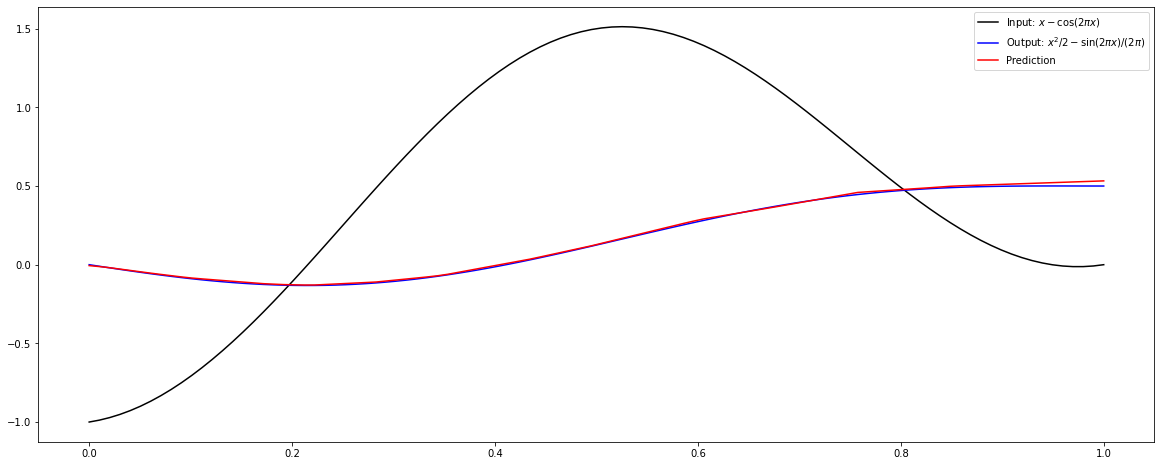

In [79]:
plot(data_res, torch.load('model/model{}.pkl'.format(5000)))